# Scene Recognition using Bag of Visual Words
___
*Jivitesh Jain, 2018101092*

Here, we perform a scene recognition and classification task using the classic **Bag of Visual Words (BoVW)** technique, popular in Natural Language Processing as 'Bag of Words'.  

The technique extracts features out of a training corpus of images, clusters similar features to form **visual words** and uses **histograms of the presence of these words in images as features for classification.** We train **one-vs-all linear SVM classifiers** on features from images of the 8 training classes and use these to classify the test set.  

We use **TF-IDF re-weighting** to focus on distinguishing words. We also implement **spatial pyramid matching**, which tries to encode spatial information (about the location of occurence of these visual words) into the feature set, drastically improving results.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import math
from collections import namedtuple
from tqdm.auto import tqdm as tq
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from pprint import pprint
import seaborn as sns
sns.set()

In [2]:
CLASSES = ['aquarium', 'desert', 'highway', 'kitchen', 'laundromat', 'park', 'waterfall', 'windmill']
PATHS = namedtuple('_', ('train', 'test'))('../dataset/SUN_data/train/', '../dataset/SUN_data/test/')
SIZE = (148, 148)

Here, we use generators as data loaders. This ensures that more than one image is never in memory while processing. Because SIFT feature calculation is memory intensive, this helps in keeping the overall memory consumption of the process low.  

We resize all images to $148 \times 148$ pixels to reduce the computational complexity. The awkward size is chosen to be divisible into tiles while constructing the spatial pyramid quad-tree.

In [3]:
def alert(f):
    def wrapper(*args, **kwargs):
        ret = f(*args, **kwargs)
        try:
            display(Audio(audio_file, autoplay=True))
        finally:
            return ret
    from IPython.display import Audio
    audio_file = 'http://www.soundjay.com/button/beep-07.wav'
    return wrapper

def show(img, ax=None):
    if not ax:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        return ax

def load_test(cls, lim=None):
    path = os.path.join(PATHS.test, cls)
    imgs = os.listdir(path)
    if (lim is not None) and (len(imgs) > lim):
        imgs = imgs[:lim]
    for f in imgs:
        if f.startswith('.'):
            continue
        f_ = os.path.join(path, f)
        img = cv2.imread(f_)
        img = cv2.resize(img, SIZE, interpolation=cv2.INTER_AREA)
        yield f_, img

def load_train(cls, lim=None):
    path = os.path.join(PATHS.train, cls)
    imgs = os.listdir(path)
    if (lim is not None) and (len(imgs) > lim):
        imgs = imgs[:lim]
    for f in imgs:
        if f.startswith('.'):
            continue
        f_ = os.path.join(path, f)
        img = cv2.imread(f_)
        img = cv2.resize(img, SIZE, interpolation=cv2.INTER_AREA)
        yield f_, img
        
def load_test_all(lim=None):
    for cls in CLASSES:
        for path, img in load_test(cls, lim):
            yield cls, path, img
            
def load_train_all(lim=None):
    for cls in CLASSES:
        for path, img in load_train(cls, lim):
            yield cls, path, img

The following functions implement major parts of the algorithm:

* We first extract SIFT features densely. The functions `dense_sift` and `dense_sift_batch` run SIFT on a grid of points separated by some stride. This stride can be adjusted to weigh accuracy against computational time and speed. Because each image is the same size and SIFT is run densely, we extract the same number of features (in our case, $1369$) out of all images.

* The function `cluster` then uses the K-Means algorithm to cluster all the sift features from all the images of all categories into a predefined number of visual words. We choose a vocabulary size of $200$. The effect of this hyperparameter is discussed later.

* Once the SIFT features are clustered, we construct per-image histograms of the binning of these features into clusters. This transforms our per-image feature vector from size $1369 \times 128$ (several SIFT descriptors) to a size $1 \times 200$ (the vocabulary size). Clubbing similar features together also helps match robustly in the presence of different instances of the same object, geometric and photographic variations etc. The function `bin_histogram` is responsible for this.

* Because the weights in the histogram of any single image depend on the number of features in the image, which is same across all images in our case (SIFT run densely on identically resized images) - there is no need of histogram normalization. However, some visual words can appear in a lot of images, and thus not provide much distinguishing power, while unique visual words are more helpful for classification. To weigh the words accordingly before training the classifier, we perform a TF-IDF re-weighting, down-weighting words that occur in a lot of images. The class `TF-IDF` is used to perform this, storing the weights to equivalently re-weight the query histograms as well.
$$
w_{i, j} = tf_{i, j} \times log\left( \frac{N}{df_i + 1} \right)
$$
where:  
$tf_{i, j}$ is the number of occurences of word i in image j  
$df_i$ is the number of images containing word i
$N$ is the total number of documents

* Once we have the re-weighted histograms for the entire training set, as well as the ground truth scene labels, we train a linear one-vs-all SVM classifier over them. The function `train_classifier` performs this.

In [4]:
STEP = 4
VOCAB_SIZE = 200
SVM_LAMDA = 10
SVM_ITER = 2000

def dense_sift(img, step=STEP):
    keypoints = []
    for i in range(step//2, img.shape[0], step):
        for j in range(step//2, img.shape[1], step):
            keypoints.append(cv2.KeyPoint(j, i, step))
    
    sift = cv2.SIFT_create()
    return sift.compute(img, keypoints)

@alert
def dense_sift_batch(batch, step=STEP):
    labels = []
    paths = []
    keypoints = []
    descriptors = []
    for cls, path, img in tq(batch):
        labels.append(cls)
        paths.append(path)
        kps, desc = dense_sift(img, step)
        keypoints.append(kps)
        descriptors.append(desc)
    return labels, paths, keypoints, descriptors

def bin_histograms(labels, descriptors, k):
    
    histograms = np.zeros((len(descriptors), k), dtype=np.float64)
    idx = 0
    for i, desc in enumerate(descriptors):
        for _ in range(desc.shape[0]):
            histograms[i, labels[idx]] += 1
            idx += 1
    return histograms

def cluster(descriptors, k=VOCAB_SIZE, kmeans=None):
    descriptors_flat = np.concatenate(descriptors)
    
    if kmeans is None:
        kmeans = KMeans(n_clusters=k, n_init=5, n_jobs=20)
        cluster_labels = kmeans.fit_predict(descriptors_flat)
    else:
        cluster_labels = kmeans.predict(descriptors_flat)
        k = kmeans.cluster_centers_.shape[0]
    
    histograms = bin_histograms(cluster_labels, descriptors, k)
            
    return kmeans, histograms

class TFIDF:
    def __init__(self):
        self.log_weights = None
    def normalise(self, histograms):
        if self.log_weights is None:
            weights = np.count_nonzero(histograms, axis=0) + 1
            self.log_weights = np.log(histograms.shape[0] / weights)
            
        return histograms * self.log_weights
    
def train_classifier(histograms, labels, num_iter=SVM_ITER, lamda=SVM_LAMDA):
    labels = np.array(labels, dtype='object')
    svm = LinearSVC(C=lamda, max_iter=num_iter, dual=(histograms.shape[0]<=histograms.shape[1])).fit(histograms, labels)
    return svm

In [5]:
tr_labels, _, tr_keypoints, tr_descriptors = dense_sift_batch(load_train_all())
kmeans, tr_histograms = cluster(tr_descriptors)
tfidf = TFIDF()
tr_norm_histograms = tfidf.normalise(tr_histograms)
classifier = train_classifier(tr_norm_histograms, tr_labels)

0it [00:00, ?it/s]

/media/data_dump/Shivangi/Jivitesh/tmp/assignment-4-jiviteshjain/env/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
/media/data_dump/Shivangi/Jivitesh/tmp/assignment-4-jiviteshjain/env/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [6]:
te_labels, te_paths, _, te_descriptors = dense_sift_batch(load_test_all())
_, te_histograms = cluster(te_descriptors, kmeans=kmeans)
te_norm_histograms = tfidf.normalise(te_histograms)
te_labels_pred = classifier.predict(te_norm_histograms)
tr_labels_pred = classifier.predict(tr_norm_histograms)

0it [00:00, ?it/s]

In [7]:
def confusion(actual, predicted, classes):
    conf = np.zeros((len(classes), len(classes)), dtype=np.float64)
    
    mp = {}
    for i, cls in enumerate(classes):
        mp[cls] = i
    
    for a, p in zip(actual, predicted):
        conf[mp[a], mp[p]] += 1
    return conf / conf.sum(axis=1, keepdims=True)

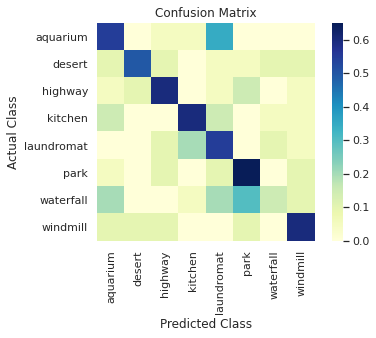

In [8]:
conf = confusion(te_labels, te_labels_pred, CLASSES)
ax = sns.heatmap(conf, cmap='YlGnBu', xticklabels=CLASSES, yticklabels=CLASSES, square=True)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
plt.show()

In [9]:
NUM_PLOT = 10

tr_labels = np.array(tr_labels, dtype='object')
tr_good_ind = np.where(np.equal(tr_labels, tr_labels_pred))[0]

acc = len(tr_good_ind) * 100 / len(tr_labels)
print(f'Train Accuracy: {acc}%')

te_labels = np.array(te_labels, dtype='object')
good_ind = np.where(np.equal(te_labels, te_labels_pred))[0]
bad_ind = np.where(np.not_equal(te_labels, te_labels_pred))[0]

acc = len(good_ind) * 100 / len(te_labels)
print(f'Test Accuracy: {acc}%')

good_ind = np.random.choice(good_ind, size=min(len(good_ind), NUM_PLOT), replace=False)
bad_ind = np.random.choice(bad_ind, size=min(len(bad_ind), NUM_PLOT), replace=False)

Train Accuracy: 100.0%
Test Accuracy: 52.5%


The confusion matrix on the test set is largely diagonal.
We achieve a training accuracy of $100\%$, although the test accuracy is only a $52.5\%$. This is however, significantly better than the coin-toss accuracy of $12.5\%$, providing a sanity check towards the functioning of the model. We improve this significantly later by incorporating spatial information, and discuss more in the Results and Experimentation section. First, we display some correctly and incorrectly classified samples from the test set.

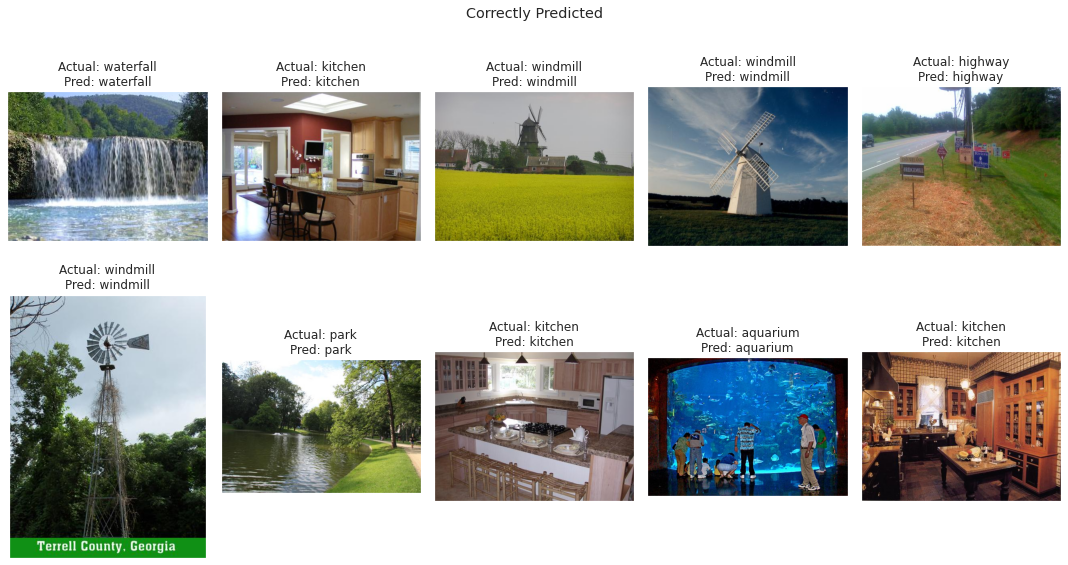

In [10]:
fig, axs = plt.subplots(2, math.ceil(len(good_ind)/2), figsize=(15, 8))

for i, ax in enumerate(axs.flat):
    if i >= len(good_ind):
        ax.imshow(np.ones((75, 75, 3)))
        ax.axis('off')
        continue
    
    idx = good_ind[i]
    img = cv2.imread(te_paths[idx])
    ax = show(img, ax)
    ax.set_title(f'Actual: {te_labels[idx]}\nPred: {te_labels_pred[idx]}')
    ax.set_xticks([], minor=[])
    ax.set_yticks([], minor=[])

fig.suptitle('Correctly Predicted')
fig.tight_layout()
plt.show()

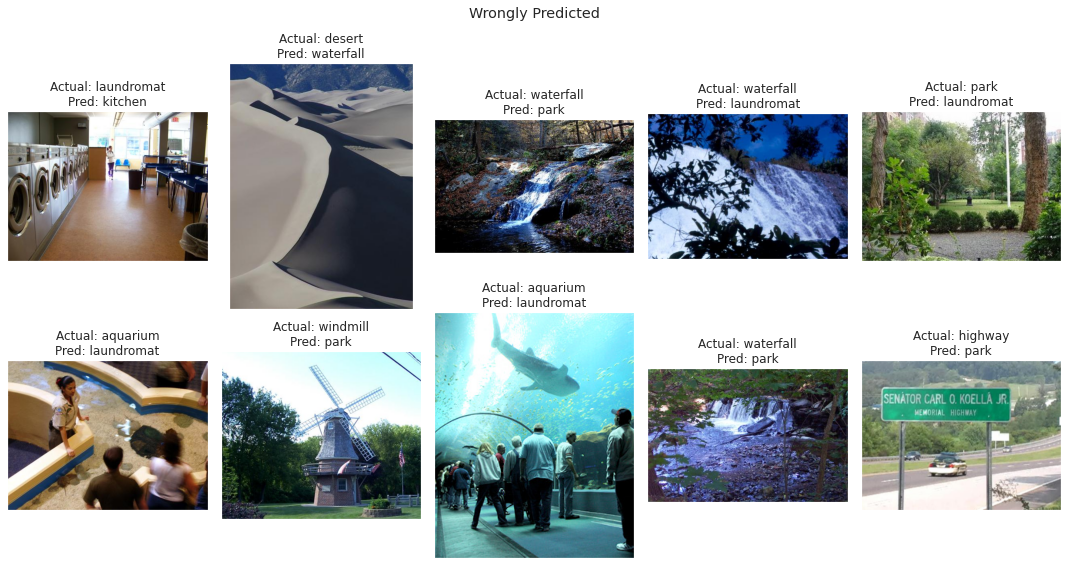

In [11]:
fig, axs = plt.subplots(2, math.ceil(len(bad_ind)/2), figsize=(15, 8))

for i, ax in enumerate(axs.flat):
    if i >= len(bad_ind):
        ax.imshow(np.ones((75, 75, 3)))
        ax.axis('off')
        continue
    
    idx = bad_ind[i]
    img = cv2.imread(te_paths[idx])
    ax = show(img, ax)
    ax.set_title(f'Actual: {te_labels[idx]}\nPred: {te_labels_pred[idx]}')
    ax.set_xticks([], minor=[])
    ax.set_yticks([], minor=[])

fig.suptitle('Wrongly Predicted')
fig.tight_layout()
plt.show()

We can't help but notice that several of the mis-classified images actually do resemble the predicted classes. The highway on the bottom-right has several green areas to the side, and so do the two waterfalls to its left - confusing the classifier into thinking of them as parks. Laundromats and Kitchens can easily be mixed up, because of the similar colours and arrangements of washing machines and chairs and tables.

## Spatial Pyramid

Here, we try to incorporate spatial information about the occurences of visual words in our histogram features, to improve the quality of classification.

We do this by analysing the image at several levels of a spatial pyramid, $i = 0, 1, 2, ..., L$. At each level $i$, the image is divided into a $2^i \times 2^i$ grid, and each cell of the grid is separately constructed into a histogram. Note that the clusters used for grouping descriptors remain the same across the cells as well as across levels. For purposes of computational efficiency, we only calculate SIFT descriptors once and re-use them across levels.  

Thus, we get $4^i$ histograms at each level $i$, which we concatenate together into a single histogram of size $4^i \times v$, where $v$ is the vocabulary size. Then, we weigh the concatenated histograms at each level according to preset weights, giving more weight to deeper levels, because of the higher spatial granularity.  

Finally, the weighted histograms for each level are concatenated together to form a single histogram for the image, which acts as the feature vector. Here, while the histogram at $i=0$ captures visual words in the entire image, histograms at deeper levels capture them only in certain spatial locations, and thus would only match with the same visual words occuring in those same locations. This makes the feature matching more robust, and thus deeper levels are weighted higher.  

We use a vocabulary of size $200$, with 3 levels, giving us a final feature vector of size $4200$. The level weights used are $0.25, 0.25, 0.5$ respectively for the three levels.

In [12]:
LEVEL_WEIGHTS = [0.25, 0.25, 0.5]

def blockshaped(arr, nrows, ncols):
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def histograms_pyramid(keypoints, descriptors, cluster_labels, image_shape=SIZE, level_weights=LEVEL_WEIGHTS, k=VOCAB_SIZE):
    keypoint_positions = np.full(image_shape[:2], -1)
    for i, kp in enumerate(keypoints[0]):
        keypoint_positions[int(kp.pt[0]), int(kp.pt[1])] = i
    
    histograms = np.empty((len(descriptors), 0), dtype=np.float64)
    labels_list = []
    idx = 0
    for i, d in enumerate(descriptors):
        labels_list.append(cluster_labels[idx:idx+d.shape[0]])
        idx += d.shape[0]
    
    for i, w in enumerate(level_weights):
        sz_r = image_shape[0] // (2**i)
        sz_c = image_shape[1] // (2**i)
        blocks = blockshaped(keypoint_positions, sz_r, sz_c)
        blocks = [np.ravel(blocks[i, :, :]) for i in range(blocks.shape[0])]
        blocks = [b[b != -1] for b in blocks]
        for b in blocks:
            sel_desc = [d[b, :] for d in descriptors]
            sel_lab = [l[b] for l in labels_list]
            
            hist = w * bin_histograms(np.concatenate(sel_lab), sel_desc, k)
            histograms = np.hstack((histograms, hist))
            
    return histograms    

def cluster_pyramid(keypoints, descriptors, image_shape=SIZE, k=VOCAB_SIZE, level_weights=LEVEL_WEIGHTS, kmeans=None):
    descriptors_flat = np.concatenate(descriptors)
    
    if kmeans is None:
        kmeans = KMeans(n_clusters=k)
        cluster_labels = kmeans.fit_predict(descriptors_flat)
    else:
        cluster_labels = kmeans.predict(descriptors_flat)
        k = kmeans.cluster_centers_.shape[0]
    
    histograms = histograms_pyramid(keypoints, descriptors, cluster_labels, image_shape, level_weights, k)
            
    return kmeans, histograms

For purposes of efficiency, the code here reuses as much of the calculated entities as possible. The SIFT descriptors are calculated only once, across grids and levels, and those too are re-used from the run above. Because the clustering is not hierarchical, it is also reused from the run earlier.

In [13]:
kmeans, tr_histograms = cluster_pyramid(tr_keypoints, tr_descriptors, kmeans=kmeans)
tfidf = TFIDF()
tr_norm_histograms = tfidf.normalise(tr_histograms)
classifier = train_classifier(tr_norm_histograms, tr_labels)

In [14]:
te_labels, te_paths, te_keypoints, te_descriptors = dense_sift_batch(load_test_all())
_, te_histograms = cluster_pyramid(te_keypoints, te_descriptors, kmeans=kmeans)
te_norm_histograms = tfidf.normalise(te_histograms)
te_labels_pred = classifier.predict(te_norm_histograms)
tr_labels_pred = classifier.predict(tr_norm_histograms)

0it [00:00, ?it/s]

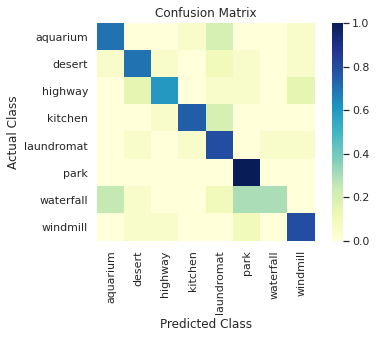

In [15]:
conf = confusion(te_labels, te_labels_pred, CLASSES)
ax = sns.heatmap(conf, cmap='YlGnBu', xticklabels=CLASSES, yticklabels=CLASSES, square=True)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
plt.show()

In [16]:
tr_labels = np.array(tr_labels, dtype='object')
tr_good_ind = np.where(np.equal(tr_labels, tr_labels_pred))[0]

acc = len(tr_good_ind) * 100 / len(tr_labels)
print(f'Train Accuracy: {acc}%')

te_labels = np.array(te_labels, dtype='object')
good_ind = np.where(np.equal(te_labels, te_labels_pred))[0]

acc = len(good_ind) * 100 / len(te_labels)
print(f'Test Accuracy: {acc}%')

Train Accuracy: 100.0%
Test Accuracy: 70.625%


We obtain a significantly higher test accuracy of 70.625%, demonstrating the utility and robustness of this approach.

### Without TF/IDF

The use of TF-IDF on the weighted spatial histogram is questionable, because it can disturb the spatial weights. Running the classification without TF-IDF re-weighting actually slightly improves the test accuracy in this case. We also plot the confusion matrix without TF-IDF re-weighting. Note that as explaned earlier, no normalisation is necessary, even in the absence of TF-IDF, as all images (and all grids) have the same number of features.

0it [00:00, ?it/s]

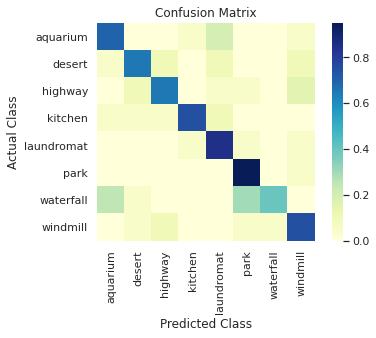

Train Accuracy: 100.0%
Test Accuracy: 71.25%


In [18]:
classifier = train_classifier(tr_histograms, tr_labels)
te_labels, te_paths, te_keypoints, te_descriptors = dense_sift_batch(load_test_all())
_, te_histograms = cluster_pyramid(te_keypoints, te_descriptors, kmeans=kmeans)
te_labels_pred = classifier.predict(te_histograms)
tr_labels_pred = classifier.predict(tr_histograms)

conf = confusion(te_labels, te_labels_pred, CLASSES)
ax = sns.heatmap(conf, cmap='YlGnBu', xticklabels=CLASSES, yticklabels=CLASSES, square=True)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
plt.show()

tr_labels = np.array(tr_labels, dtype='object')
tr_good_ind = np.where(np.equal(tr_labels, tr_labels_pred))[0]

acc = len(tr_good_ind) * 100 / len(tr_labels)
print(f'Train Accuracy: {acc}%')

te_labels = np.array(te_labels, dtype='object')
good_ind = np.where(np.equal(te_labels, te_labels_pred))[0]

acc = len(good_ind) * 100 / len(te_labels)
print(f'Test Accuracy: {acc}%')

## Results and Experimentation

*All results here are on histograms without spatial matching information.*

The most influential parameters here are the vocabulary size and the parameters (such as regularization parameter, $\lambda$) for the SVM classifier.  

We also experiment with the parameters (such as numnber of re-runs, maximum iterations etc.) of the K-Means clustering algorithm, however, those are just to keep the computational time low, and have only small effects on the accuracy.  

We notice that the accuracy increases on increasing the vocabulary size, because of finer grained clustering. We report test accuracy scores of approximately $48.7\%, 52.5\%$ and $54.7\%$ for vocabulary sizes of $100, 200$ and $500$, respectively. We however, keep the vocabulary size at $200$, for purposes of efficiency.  

The regularization parameter, $\lambda$, also has an effect. Setting $C$ to $10$, instead of the default $1$ (higher $C$ corresponds to a lower $\lambda$) improves the training and test accuracy slightly (test accuracy changes from $51.1\%$ to the current $52.5\%$), although the perfect training accuracy hints at overfitting.  

TF-IDF re-weighting also improves the accuracy, although only slightly.